In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load the datasets
file_2022 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-22_12-00_AM_1_Year_1732084536_v2.xlsx')
file_2023 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-23_12-00_AM_1_Year_1732084578_v2.xlsx')
file_2024 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-24_12-00_AM_1_Year_1732084607_v2.xlsx')

# Select required columns
cols_needed = ['Date & Time', 'Rain - mm']
df_2022 = file_2022[cols_needed]
df_2023 = file_2023[cols_needed]
df_2024 = file_2024[cols_needed]

# Combine all datasets
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

In [3]:
# Convert 'Date & Time' to datetime
combined_df['Date & Time'] = pd.to_datetime(combined_df['Date & Time'])

# Set 'Date & Time' as the index
combined_df.set_index('Date & Time', inplace=True)

# Add additional features such as 'hour' and 'day_of_week'
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

In [4]:
# Normalize the data (scaling features and labels separately)
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

In [5]:
def normalize_data(data):
    normalized_data = data.copy()
    features = ['Rain - mm', 'hour', 'day_of_week']
    normalized_data[features] = scaler_features.fit_transform(data[features])
    normalized_data[['Rain - mm']] = scaler_labels.fit_transform(data[['Rain - mm']])
    return normalized_data

normalized_df = normalize_data(combined_df)

# Save the scalers
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_labels, 'scaler_labels.pkl')

['scaler_labels.pkl']

In [6]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length, target_column):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length, :].values
        label = data.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length for prediction (e.g., 30 time steps for a prediction horizon)
sequence_length = 30

# Create sequences for 1-hour prediction using 15-minute data
X, y = create_lstm_sequences(normalized_df, sequence_length, 'Rain - mm')

# Reshape the data for LSTM input (samples, time steps, features)
X = X.astype('float32').reshape(X.shape[0], X.shape[1], X.shape[2])

# Save the prepared sequences
np.save('X_sequences.npy', X)
np.save('y_labels.npy', y)

In [7]:
# Build LSTM model
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

In [8]:
# Function to calculate accuracy based on tolerance
def calculate_accuracy(y_true, y_pred, tolerance=0.1, epsilon=1e-10):
    accurate_preds = np.abs((y_true - y_pred) / (y_true + epsilon)) <= tolerance
    accuracy = np.mean(accurate_preds) * 100
    return accuracy

In [9]:
# Train and evaluate the model
def train_and_evaluate(X, y, title, tolerance=0.1):
    input_shape = (X.shape[1], X.shape[2])  # Shape of (time_steps, features)
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    accuracy_scores = []
    all_predictions = []
    all_actuals = []

    for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Build and train the model
        model = build_lstm_model(input_shape)
        model.fit(
            X_train, y_train,
            epochs=20, batch_size=64,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # Predict on the test set
        predictions = model.predict(X_test).flatten()

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        accuracy = calculate_accuracy(y_test, predictions, tolerance)

        # Store the metrics
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        all_predictions.extend(predictions)
        all_actuals.extend(y_test)

    # Average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"{title} Metrics:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  R²: {avg_r2:.4f}")
    print(f"  Accuracy: {avg_accuracy:.2f}%")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(all_actuals, label='Actual', color='blue', alpha=0.6)
    plt.plot(all_predictions, label='Predicted', color='red', alpha=0.6)
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Rainfall Rate')
    plt.legend()
    plt.grid()
    plt.show() 
    return model

Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0212 - val_loss: 0.0708
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0196 - val_loss: 0.0695
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0176 - val_loss: 0.0680
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0086 - val_loss: 0.0666
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0122 - val_loss: 0.0652
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0140 - val_loss: 0.0637
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0120 - val_loss: 0.0624
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0091 - val_loss: 0.0607
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0120 - val_loss: 0.0585
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0125 - val_loss: 0.0571
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0152 - val_loss: 0.0559
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 

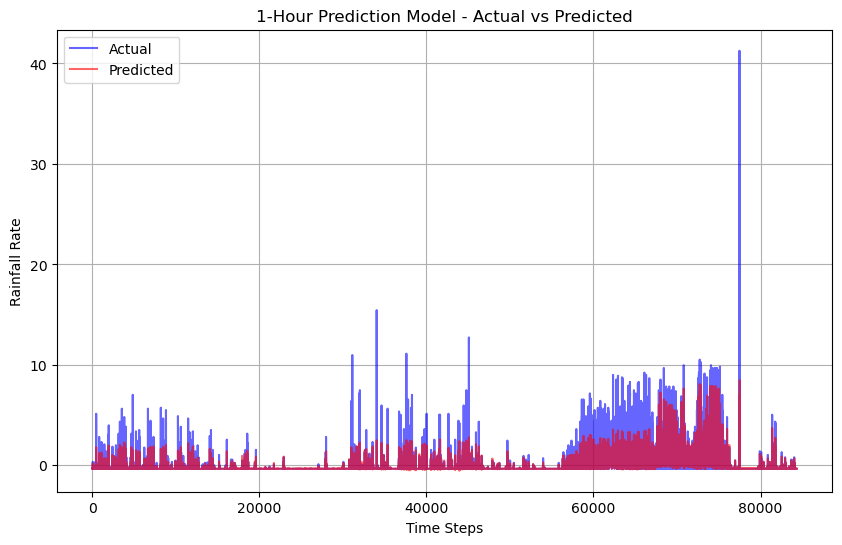

In [10]:
# Train and evaluate the model for 1-hour prediction
model_1hr = train_and_evaluate(X, y, '1-Hour Prediction Model', tolerance=0.1)

In [11]:
import os

# Save the 15-minute prediction model with the .h5 extension
model_1hr_filename = 'model_15minfor1hr(1).h5'
model_1hr.save(model_1hr_filename)
print(f"15-Minute Prediction Model saved as '{os.path.abspath(model_1hr_filename)}'")


NameError: name 'model_15min_filename' is not defined